### Imports

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torch.utils.tensorboard import SummaryWriter
from scripts.data.dataset import DSLRDataset
from scripts.data.transforms import ToTensor, Normalize
from scripts.utils.load_save_models import save_checkpoint, get_latest_checkpoint, inference, load_checkpoint
from scripts.utils.visualizer import visualize_predictions, visualize_dataloader

# Set CUDA_LAUNCH_BLOCKING for accurate stack trace
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Clear GPU cache
torch.cuda.empty_cache()

# Set PYTORCH_CUDA_ALLOC_CONF to manage memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:32'



### Prepare for Dataset

In [2]:
# Paths to dataset and split files
data_dir = 'dataset/data/data_2d'
train_split_file = 'dataset/splits/nvs_sem_train.txt'
val_split_file = 'dataset/splits/nvs_sem_val.txt'

# Define the transforms
transform = T.Compose([
    ToTensor(),
    # Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



# ################## Debug: Dataset ########################################

# data_2d_dir = 'dataset/data/data_2d'
# train_split_file = 'dataset/splits/nvs_sem_train.txt'
# transform =transform = T.Compose([ ToTensor(),])

# train_set = DSLRDataset(data_2d_dir, train_split_file, transform)

# print(f"Number of samples in the dataset: {len(train_set)}")


    
# # Get a dataloader
# train_loader = DataLoader(train_set, batch_size=2, shuffle=True)

# # Get a loop to execute the Process a random sample in batch

# for epoch in range(3):
#     for i, batch in enumerate(train_loader):
#         batch_list = batch['scene_id']
#         print(f"Batch list at batch [{i}]: \n\tbatch_list = {batch_list}")
#     print(f' Epoch: {epoch}')
# ##########################################################################


### Dataset

In [3]:
# Create datasets and dataloaders
train_dataset = DSLRDataset(data_dir, train_split_file, transform=transform)
val_dataset = DSLRDataset(data_dir, val_split_file, transform=transform)


# Get length of datasets
train_len = len(train_dataset)
val_len = len(val_dataset)
print('Train dataset length:', train_len)
print('Val dataset length:', val_len)


# check a random sample's shape:
idx = torch.randint(0, train_len, (1,)).item()
sample = train_dataset[idx]
print(f'Random sample shape: {idx}', sample['depth'].shape)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=8)


# check if the dataloader's shapes are correct, including the batch size
print('Train dataloader shape:', next(iter(train_loader))['image'].shape)
print('Val dataloader shape:', next(iter(val_loader))['image'].shape)




Train dataset length: 4
Val dataset length: 4
Random sample shape: 0 torch.Size([2, 448, 672])
Train dataloader shape: torch.Size([1, 2, 3, 448, 672])
Val dataloader shape: torch.Size([1, 2, 3, 448, 672])


### Visualize first

Visualizing data from the dataloader...
Loaded palette: [[0.40784314 0.8        1.        ]
 [0.7372549  0.74117647 0.13333333]
 [0.59607843 0.8745098  0.54117647]
 [1.         0.59607843 0.58823529]
 [0.83921569 0.15294118 0.15686275]]
Input image 1 shape: (448, 672, 3), min: 0.0, max: 1.0
Input image 2 shape: (448, 672, 3), min: 0.0, max: 1.0
Label image shape: (448, 672), unique values: [-100   -1    0    2    3    6    9   13   15   18   21   61]
Label image shape: (448, 672), unique values: [-100   -1    0    2    3    4    9   55   70]
Input image 1 shape: (448, 672, 3), min: 0.0, max: 1.0
Input image 2 shape: (448, 672, 3), min: 0.0, max: 1.0
Label image shape: (448, 672), unique values: [-100   -1    0    1    2    3    5    6    7    9   15   17   20   28
   43   46   56   65   73   84]
Label image shape: (448, 672), unique values: [-100   -1    0    2    3    4    6    9   20   27   37   46   56]


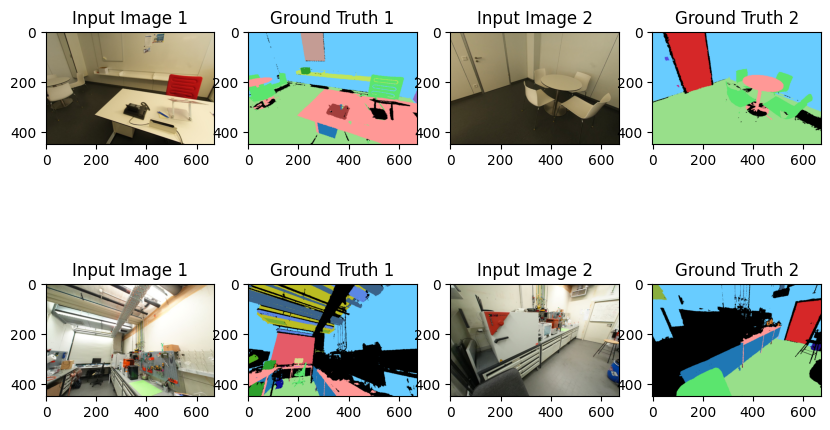

In [4]:
# Visualize data from the dataloader before training
print("Visualizing data from the dataloader...")
visualize_dataloader(val_loader, palette_file='scripts/utils/palette_scannet200.txt', num_samples=2)

### Training preparation

In [5]:
from scripts.networks.nn_2d_segformer import Segformer_Segmentation
from scripts.networks.nn_spconv import SimpleSpConvNet

# Clear GPU cache
torch.cuda.empty_cache()
# Instantiate the model and move it to the device: SegFormer

model = Segformer_Segmentation(num_classes=101) #注意cuda out of memory, 需要修改scripts/networks/nn_2d_segformer.py里面的结构


# model3d = SimpleSpConvNet(num_classes=101)

# model to device
model = model.to(device)
# model3d = model3d.to(device)

# Define the ignore index for invalid labels
IGNORE_INDEX = -1

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

optimizer_2d = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 

# 3d
# optimizer_3d = optim.Adam(model3d.parameters(), lr=0.001, weight_decay=1e-5)

# Check the model architecture
print(model)
# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir='./runs')


/home/lukas/anaconda3/envs/d/lib/python3.9/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Segformer_Segmentation(
  (backbone): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 160, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((160,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(160, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        )
   

### Load the latest

In [6]:
from scripts.utils.load_save_models import get_latest_checkpoint
# Create the checkpoints directory
checkpoint_dir = './checkpoints'

# Load latest checkpoint if available
latest_checkpoint = get_latest_checkpoint(checkpoint_dir)
start_epoch = 0
if latest_checkpoint:
    start_epoch, _ = load_checkpoint(latest_checkpoint, model, optimizer_2d)
    print(f"Resuming training from epoch {start_epoch}")


### Train loop

In [7]:
import torch
import torch.nn.functional as F
from scripts.networks.utils_projection import project_to_3d
from scripts.networks.utils_projection import apply_softmax, colorize_point_cloud, save_point_cloud_to_ply,load_palette
from scripts.networks.utils_voxelization import PC2Tensor


# 定义计算准确率的函数 # 两张还没想好怎么计算
def calculate_accuracy(outputs, labels, ignore_index):
    # 获取预测的标签
    preds = torch.argmax(outputs, dim=1)
    valid_mask = labels != ignore_index
    correct = torch.sum(preds[valid_mask] == labels[valid_mask]).item()
    return correct
# Training loop
num_epochs = 600
save_interval = 10  # Save a checkpoint every 10 epochs

for epoch in range(start_epoch, num_epochs):

    model.train() # set 2D network to eval mode when training 3D network
    running_loss_2d = 0.0
    running_loss = 0.0
    running_corrects1 = 0
    running_corrects2 = 0
    running_corrects = 0
    total_samples = 0
    # for every batch
    for i, images in enumerate(train_loader):
        #########################################
        # 首先传递batch_list给3D网络
        batch_list = images['scene_id']
        print(f' Epoch: {epoch}, Batch: {i}\n\tbatch_list={batch_list}')
        
        #########################################
        # 得到2D的输入和labels
        inputs = images['image'].to(device)
        labels = images['label'].to(device)
        
        
        ##############################################
        #这里可以加入相机的内参外参
        depth = images['depth'].to(device)
        R = images['R'].to(device)
        T = images['T'].to(device)
        K = images['intrinsic_mat'].to(device)
        
        
        ##############################################
        # 分别得到两张图片的参数
        ### Inputs
        # Split the inputs into two for each image along the second dimension
        inputs1, inputs2 = torch.split(inputs, 1, dim=1)  # Shape: (batch_size, 1, 3, height, width)
        
        # Remove the second dimension
        inputs1 = inputs1.squeeze(1)  # Shape: (batch_size, 3, height, width)
        inputs2 = inputs2.squeeze(1)  # Shape: (batch_size, 3, height, width)
        
        ### Labels
        # Split the labels into two for each image along the second dimension
        labels1, labels2 = torch.split(labels, 1, dim=1)  # Shape: (batch_size, 1, height, width)
        
        # Remove the second dimension
        labels1 = labels1.squeeze(1)  # Shape: (batch_size, height, width)
        labels2 = labels2.squeeze(1)  # Shape: (batch_size, height, width)
        
        ### Depth
        depth1, depth2 = torch.split(depth, 1, dim=1)
        depth1 = depth1.squeeze(1)
        depth2 = depth2.squeeze(1)
        
        ### R, T, K
        R1,R2 = torch.split(R, 1, dim=1)
        R1 = R1.squeeze(1)
        R2 = R2.squeeze(1)
        
        T1,T2 = torch.split(T, 1, dim=1)
        T1 = T1.squeeze(1)
        T2 = T2.squeeze(1)
        
        K1,K2 = torch.split(K, 1, dim=1)
        K1 = K1.squeeze(1)
        K2 = K2.squeeze(1)
        
        
        # 对于未标注的类别，设置为IGNORE_INDEX
        # Identify invalid labels and set them to IGNORE_INDEX
        invalid_mask1 = (labels1 >= 100) | (labels1 < 0)
        invalid_mask2 = (labels2 >= 100) | (labels2 < 0)
        labels1[invalid_mask1] = IGNORE_INDEX
        labels2[invalid_mask2] = IGNORE_INDEX

        # Zero the parameter gradients
        optimizer_2d.zero_grad()
        
        # Forward pass
        outputs1 = model(inputs1)
        outputs2 = model(inputs2)
        
        ##### The following loss should not be calculated while training the 3D network, set 2D network to eval mode
        loss2d_1 = criterion(outputs1, labels1)
        loss2d_2 = criterion(outputs2, labels2)

        loss2d_1.backward(retain_graph=True)
        optimizer_2d.step()
        
        loss2d_2.backward()
        optimizer_2d.step()
        
        # Calculate the total loss to print
        loss2d = (loss2d_1 + loss2d_2)/2
        
        running_loss += loss2d.item()
        
        # # 计算准确率
        corrects1 = calculate_accuracy(outputs1, labels1, IGNORE_INDEX)
        running_corrects1 += corrects1 * inputs.size(0)
        corrects2 = calculate_accuracy(outputs2, labels2, IGNORE_INDEX)
        running_corrects2 += corrects2 * inputs.size(0)
        
        running_corrects = (running_corrects1 + running_corrects2) / 2
        
        total_samples += inputs.size(0)
        

        ##########################################################################################################
        # # # 特征点云的生成
        point_cloud_features1 = project_to_3d(outputs1, depth1, K1, R1, T1, ignore_index=IGNORE_INDEX) # Shape: (batch_size, num_points, 3 + num_classes)
        point_cloud_features2 = project_to_3d(outputs2, depth2, K2, R2, T2, ignore_index=IGNORE_INDEX)
        # Concatenate the two point cloud features along the second dimension
        point_cloud_features = torch.cat((point_cloud_features1, point_cloud_features2), dim=1)  # Shape: (batch_size, 2*num_points, 3 + num_classes)
        # print('Point cloud features shape:', point_cloud_features1.shape)
        
        # # # 这个就是我们需要得到的点云特征的数据了，形状为(B, N, 3 + C_classes)
        save_path = f'./point_cloud_features_epoch_{epoch}_batch_{i}.pth'
        torch.save(point_cloud_features, save_path)
        
        #################################################
        ################TODO：3D网络从这里接入##############
        '''
        接下来可能有这些步骤：
        '''
        # Step 0: 2D部分最后的任务：
        # a) 尽量不修改2d网络结构，通过修改dataset，或者别的方式，使得模型可以推理两张不同的图片（同一个场景）
        # b) 模型推理两张图片，得到上述的两份特征点云，并且将两张图片的特征点云数据拼接在一起
        
        # Step 1: 定义新的dataloader用于3d训练数据，将用来提取scannetpp的点云数据作为几何信息
        
        # Step 2: 定义一个Voxelizer，用来处理任何形状为(B, N, 3)的点云数据
        
        # Step 3: 定义一个3D网络，用来处理这两部分体素化数据
        
        # 尝试接入3D网络
        
        # spatial_shape = [30, 40, 40]
        # pc2tensor = PC2Tensor(device, spatial_shape)
        # spconv_tensor = pc2tensor(point_cloud_features)
        # print('3D Input shape:', spconv_tensor)
        # torch.save(spconv_tensor, f'./spconv_tensor_epoch_{epoch}_batch_{i}.pth')
        
        

        
        
        
        
        
        
        # # 这里是用来检测点云是否生成正确，正式运行的时候可以注释掉
        # # # Apply softmax and convert to integer predictions
        # point_cloud_with_predictions = apply_softmax(point_cloud_features)
        # palette = load_palette('scripts/utils/palette_scannet200.txt')
        # # Colorize point cloud using the predictions and palette
        # point_cloud_with_colors = colorize_point_cloud(point_cloud_with_predictions, palette)
        # print('Point cloud with colors shape:', point_cloud_with_colors.shape)

        # # Save the colored point cloud to PLY files
        # save_point_cloud_to_ply(epoch, point_cloud_with_colors, './outputs')
        # ###################END OF TODO##############################################################################
        ############################################################################################################
        


    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_corrects / total_samples
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss}, Accuracy: {epoch_acc}")

    # Log training loss and accuracy to TensorBoard
    writer.add_scalar('Training Loss', epoch_loss, epoch)
    writer.add_scalar('Training Accuracy', epoch_acc, epoch)

    # # Validation loop
    # model.eval()
    # val_loss = 0.0
    # val_corrects = 0
    # val_samples = 0
    # with torch.no_grad():
    #     for i, images in enumerate(val_loader):
    #         inputs = images['image'].to(device)
    #         labels = images['label'].to(device)
    #         ####################################################
    #         ############TODO: 根据train同理修改这一部分############ 
            
    #         invalid_mask = (labels < 0)
    #         labels[invalid_mask] = IGNORE_INDEX
            
    #         outputs = model(inputs)
            
    #         loss = criterion(outputs, labels)
            
    #         val_loss += loss.item()
            
            
    #         ###############END OF TODO##########################
    #         ####################################################
    #         # 计算准确率
    #         corrects = calculate_accuracy(outputs, labels, IGNORE_INDEX)
    #         val_corrects += corrects * inputs.size(0)
    #         val_samples += inputs.size(0)

    # epoch_val_loss = val_loss / len(val_loader)
    # epoch_val_acc = val_corrects / val_samples
    # print(f"Validation Loss: {epoch_val_loss}, Validation Accuracy: {epoch_val_acc}")

    # # Log validation loss and accuracy to TensorBoard
    # writer.add_scalar('Validation Loss', epoch_val_loss, epoch)
    # writer.add_scalar('Validation Accuracy', epoch_val_acc, epoch)



    # Save a checkpoint
    if (epoch + 1) % save_interval == 0 or (epoch + 1) == num_epochs:
        save_checkpoint(epoch + 1, model, optimizer_2d, epoch_loss, checkpoint_dir, filename=f'checkpoint_epoch_{epoch+1}.pth.tar')

print("Training complete")
writer.close()


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
 Epoch: 0, Batch: 0
	batch_list=['8b5caf3398']
 Epoch: 0, Batch: 1
	batch_list=['7cd2ac43b4']
 Epoch: 0, Batch: 2
	batch_list=['40b56bf310']


### Inference and visualizations

In [ ]:
# Inference and visualize predictions
inference_checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch_400.pth.tar')
inputs, labels, predictions = inference(model, val_loader, device, inference_checkpoint_path, num_samples=1)
# Get the tensor inside the prediction

## 注意这里的visualize_predictions和visualize_dataloader，前者是用来展示预测结果的，后者是用来展示dataloader的
## 但是不得不说写的很栏，只是勉强跑通了
visualize_predictions(inputs, labels, predictions, palette_file='scripts/utils/palette_scannet200.txt')

FileNotFoundError: [Errno 2] No such file or directory: './checkpoints/checkpoint_epoch_400.pth.tar'